<a href="https://colab.research.google.com/github/parmarsuraj99/attention-experiments-keras/blob/master/MLP/Attention_FC_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
import gc, os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models
import tensorflow.keras.backend as K
from tensorflow.keras import layers as L 
from tensorflow.keras import regularizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import mnist, cifar10


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
!PYTHONHASHSEED=0

### Plotting History helper

In [0]:
def plot_hist(history):
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### MNIST loading

In [0]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
x_train_r = x_train.reshape(-1, x_train.shape[1]*x_train.shape[2])
x_test_r = x_test.reshape(-1, x_test.shape[1]*x_test.shape[2])

### Modelling

Don't know if this can be called attention as proposed in paper, but this does learn relation between fully connected layers. i.e., Weighting between the layers I have used this mechanism with input. But we might want to add this before classifier too.

In [0]:
gc.collect()

34

In [0]:
def get_mlp(input_shape=28*28, n_classes=10, with_attn=False):
    input_ = L.Input(shape=(input_shape, ))

    #Common head 
    x = L.Dense(input_shape, activation="relu", kernel_initializer=tf.keras.initializers.he_normal(seed=1), kernel_regularizer=tf.keras.regularizers.L1L2())(input_)
    x = L.Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.he_normal(seed=1), kernel_regularizer=tf.keras.regularizers.L1L2())(x)
    x = L.Dropout(0.2)(x)
    x = L.Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.he_normal(seed=1), kernel_regularizer=tf.keras.regularizers.L1L2())(x)

    if with_attn: 
        #Attention with jugaad(layer weighing)
        x = L.Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.he_normal(seed=1), kernel_regularizer=tf.keras.regularizers.L1L2())(x)
        x = L.Dropout(0.2)(x)
        x = L.Dense(32, activation='tanh',kernel_initializer=tf.keras.initializers.he_normal(seed=1), kernel_regularizer=tf.keras.regularizers.L1L2())(x)   
        
        attention_probs_2 = L.Dense(32, activation='sigmoid', name='attention_probs2', kernel_initializer=tf.keras.initializers.he_normal(seed=1), kernel_regularizer=tf.keras.regularizers.L1L2())(x)
        x = L.multiply([x, attention_probs_2], name='attention_mul2')
        
        x = L.Dense(n_classes, activation="softmax", kernel_initializer=tf.keras.initializers.he_normal(seed=1), kernel_regularizer=tf.keras.regularizers.L1L2())(x)


    else:
        #No layer weighing
        x = L.Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.he_normal(seed=1), kernel_regularizer=tf.keras.regularizers.L1L2())(x)
        x = L.Dropout(0.2)(x)
        
        x = L.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal(seed=1), kernel_regularizer=tf.keras.regularizers.L1L2())(x)
        x = L.Dense(32, activation='tanh',kernel_initializer=tf.keras.initializers.he_normal(seed=1), kernel_regularizer=tf.keras.regularizers.L1L2())(x)   
        x = L.Dense(n_classes, activation="softmax", kernel_initializer=tf.keras.initializers.he_normal(seed=1), kernel_regularizer=tf.keras.regularizers.L1L2())(x)
        
        
    
    model = models.Model(inputs=input_, outputs=x)
    return model


model_k = get_mlp(x_train_r.shape[1], n_classes=10, with_attn=False)
model_k.summary()


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_62 (Dense)             (None, 784)               615440    
_________________________________________________________________
dense_63 (Dense)             (None, 64)                50240     
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_64 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_65 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0  

### Model with layer weighing

In [0]:
model_a = get_mlp(with_attn=True)
model_a.compile("adam","categorical_crossentropy", metrics=["accuracy"])

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_88 (Dense)                (None, 784)          615440      input_16[0][0]                   
__________________________________________________________________________________________________
dense_89 (Dense)                (None, 64)           50240       dense_88[0][0]                   
__________________________________________________________________________________________________
dropout_26 (Dropout)            (None, 64)           0           dense_89[0][0]                   
___________________________________________________________________________________________

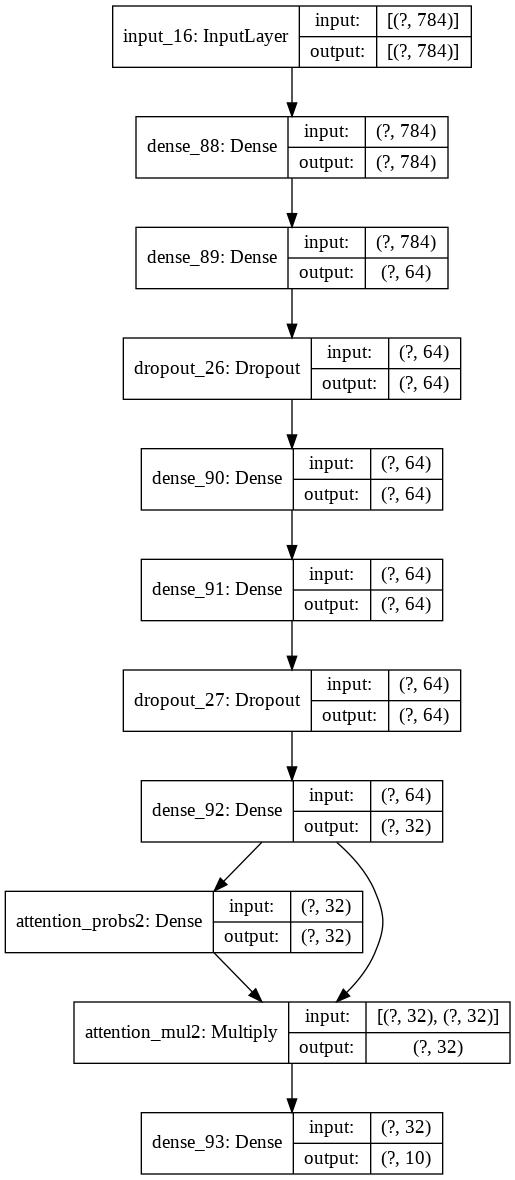

In [56]:
model_a.summary()
plot_model(model_a, show_shapes=True, expand_nested=True) 

In [57]:
hist_a = model_a.fit(x_train_r, y_train, validation_data=(x_test_r, y_test), epochs=10, batch_size=2048)

Epoch 1/10
30/30 [==============================] - 4s 119ms/step - loss: 1.5416 - accuracy: 0.5878 - val_loss: 0.7960 - val_accuracy: 0.8840
Epoch 2/10
30/30 [==============================] - 3s 114ms/step - loss: 0.7445 - accuracy: 0.8763 - val_loss: 0.4086 - val_accuracy: 0.9337
Epoch 3/10
30/30 [==============================] - 3s 114ms/step - loss: 0.4149 - accuracy: 0.9298 - val_loss: 0.2602 - val_accuracy: 0.9498
Epoch 4/10
30/30 [==============================] - 3s 114ms/step - loss: 0.2700 - accuracy: 0.9509 - val_loss: 0.1894 - val_accuracy: 0.9607
Epoch 5/10
30/30 [==============================] - 3s 114ms/step - loss: 0.2003 - accuracy: 0.9614 - val_loss: 0.1513 - val_accuracy: 0.9667
Epoch 6/10
30/30 [==============================] - 3s 114ms/step - loss: 0.1547 - accuracy: 0.9691 - val_loss: 0.1262 - val_accuracy: 0.9722
Epoch 7/10
30/30 [==============================] - 3s 114ms/step - loss: 0.1255 - accuracy: 0.9753 - val_loss: 0.1185 - val_accuracy: 0.9728
Epoch 

Test loss: 0.09309087693691254
Test accuracy: 0.9789999723434448
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


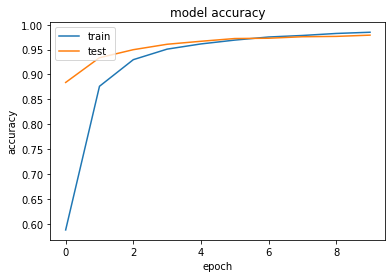

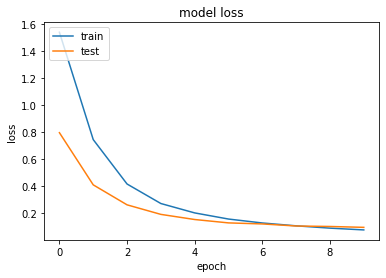

In [58]:
score = model_a.evaluate(x_test_r, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_hist(hist_a)

### Model without layer weighing

In [0]:
model_na = get_mlp(with_attn=False)
model_na.compile("adam","categorical_crossentropy", metrics=["accuracy"])

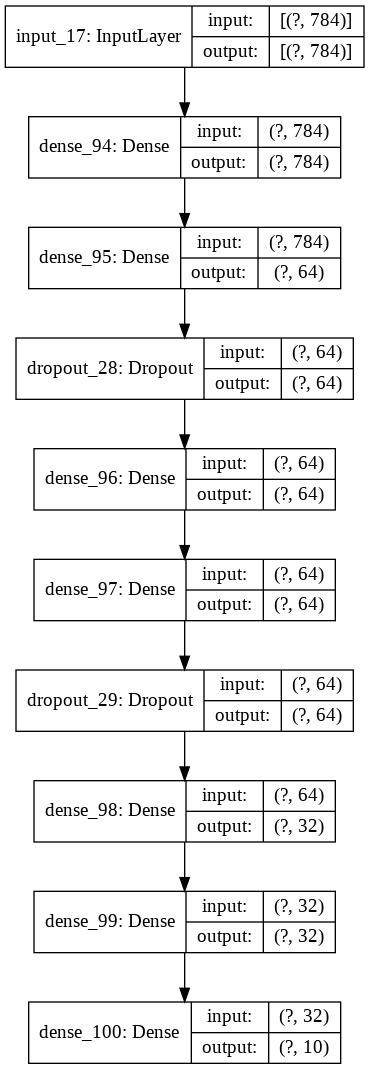

In [60]:
plot_model(model_na, show_shapes=True, expand_nested=True)

In [61]:
hist_na = model_na.fit(x_train_r, y_train, validation_data=(x_test_r, y_test), epochs=10, batch_size=2048)

Epoch 1/10
30/30 [==============================] - 4s 118ms/step - loss: 1.6209 - accuracy: 0.4636 - val_loss: 0.7180 - val_accuracy: 0.8566
Epoch 2/10
30/30 [==============================] - 3s 114ms/step - loss: 0.6546 - accuracy: 0.8439 - val_loss: 0.3181 - val_accuracy: 0.9267
Epoch 3/10
30/30 [==============================] - 3s 114ms/step - loss: 0.3613 - accuracy: 0.9152 - val_loss: 0.2270 - val_accuracy: 0.9463
Epoch 4/10
30/30 [==============================] - 3s 114ms/step - loss: 0.2540 - accuracy: 0.9400 - val_loss: 0.1739 - val_accuracy: 0.9587
Epoch 5/10
30/30 [==============================] - 3s 115ms/step - loss: 0.1915 - accuracy: 0.9551 - val_loss: 0.1448 - val_accuracy: 0.9632
Epoch 6/10
30/30 [==============================] - 3s 114ms/step - loss: 0.1556 - accuracy: 0.9643 - val_loss: 0.1255 - val_accuracy: 0.9691
Epoch 7/10
30/30 [==============================] - 3s 114ms/step - loss: 0.1283 - accuracy: 0.9697 - val_loss: 0.1161 - val_accuracy: 0.9712
Epoch 

Test loss: 0.09517688304185867
Test accuracy: 0.9757000207901001
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


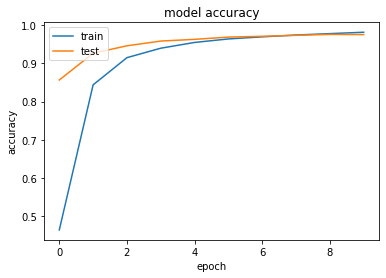

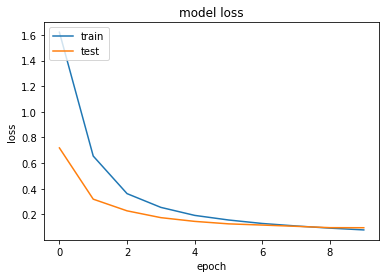

In [62]:
score = model_na.evaluate(x_test_r, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_hist(hist_na)

Observed marginal improvement. Maybe replacing all layers with 'tanh' or 'sigmoid' activation can work

In [0]:
layer_outputs = [layer.output for layer in model_a.layers[1:]] 
attn_viz = models.Model(inputs=model_a.input, outputs=layer_outputs)


layer_outputs = [layer.output for layer in model_na.layers[1:]] 
non_attn_viz = models.Model(inputs=model_na.input, outputs=layer_outputs)

True label: 7
Activations: Weigihing model
Activations: Non-Weigihing model


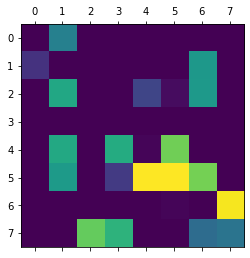

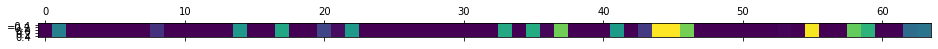

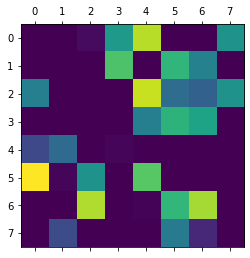

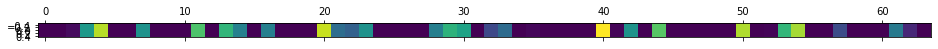

CPU times: user 476 ms, sys: 12 ms, total: 488 ms
Wall time: 493 ms


In [141]:
%%time
i=0
layer_num = -5

#print(activations_a[-3])
print(f"True label: {np.argmax(y_test[i])}")

print("Activations: Weigihing model")
activations_a = attn_viz.predict(np.expand_dims(x_test_r[i], 0)); 
plt.matshow(activations_a[layer_num].reshape(8, 8))
plt.matshow(activations_a[layer_num])

print("Activations: Non-Weigihing model")
activations_na = non_attn_viz.predict(np.expand_dims(x_test_r[i], 0))
plt.matshow(activations_na[layer_num].reshape(8, 8))
plt.matshow(activations_na[layer_num])


plt.show()